<a href="https://colab.research.google.com/github/croockshank/absensi-pengenalan-wajah/blob/main/Cropping%20Alpha%20Data%20menjadi%20Dataset%20Proyek%20Machine%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cropping Alpha Data menjadi Dataset


---

Mengambil bagian wajah saja dari data gambar yang sudah dikelompokan berdasarkan Kelas Mahasiswa dan Nama Mahasiswanya, karena fitur-fitur yang digunakan hanya khusus di wajah saja.

Untuk mencapai hal ini, digunakan library OpenCV dan memanfaatkan Classifiernya bernama Haarcascade Frontalface Default. Classifiernya ini sendiri menggunakan algoritma Haar Cascade dengan mengimplementasikan algoritma AdaBoost untuk bisa memprediksi **weak features** pada wajah.

## Beberapa referensi yang digunakan:

Algoritma Haar Cascade: <br>
* https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/
* https://medium.com/purwadhikaconnect/opencv-face-recognition-berbasis-algoritma-haar-cascade-1a5e23d9e8cb


Face Cropping dengan OpenCV:
* https://www.geeksforgeeks.org/cropping-faces-from-images-using-opencv-python/

Filter & Histogram Equalization
* https://www.pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/
* https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html
* https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html


In [ ]:
#Mendownload Classifier Haarcascade Frontalface Default

!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2021-05-07 14:19:07--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2021-05-07 14:19:07 (18.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
#Mendownload Alpha Dataset dari hasil Crop Window Zoom dan Pengelompokan sesuai kelas dan Nama Mahasiswa

import gdown

url = 'https://drive.google.com/uc?id=1OMsCJuRv3mMkkkN0fiGEAT1IY2uDm4zE'
output = 'zoom-2d2e-dataset.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1OMsCJuRv3mMkkkN0fiGEAT1IY2uDm4zE
To: /content/zoom-2d2e-dataset.zip
38.5MB [00:00, 67.0MB/s]


'zoom-2d2e-dataset.zip'

In [ ]:
# Ekstrak file Alpha Dataset yang berbentuk Zip
import zipfile

zip_path = output
zip_dir = '/content/dataset_alpha'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(zip_dir)

In [ ]:
import glob

dataset_path = zip_dir

# Ambil semua data gambar berekstensi .jpg dari folder dataset_alpha
files = glob.glob(dataset_path + '/**/*.jpg', recursive=True)

print('Ditemukan {} file gambar'.format(len(files)))

Ditemukan 998 file gambar


In [ ]:
# Melakukan proses Face Detection lalu Melakukan Crop hasil gambar wajahnya

import os
import ntpath
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from skimage.util import random_noise

# Load Classifier Haarcascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Variabel total untuk cari tahu berapa jumlah gambar yang berhasil dilakukan Face Detection dan Cropping
total = 0

# Nama folder hasil cropping nantinya
final_dataset_path = 'dataset'

print('Menyimpan gambar...')

#Iterasi semua file gambar yang ada
for idx, filename in enumerate(files, 1):

  # Load file gambarnya
  img = cv2.imread(filename)

  # Filter gambar dengan Gaussian Blur supaya sedikit halus
  img = cv2.GaussianBlur(img, (1,1), 0)
  # Filter Blending, yaitu menumpuk 2 gambar yang sama agar lebih jernih
  img = cv2.addWeighted(img, 1.5, img, -0.2, 0.0)

  # Convert gambar yang sudah difilter ke Grayscale
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # Membuat Histogram gambar agar seimbang sehingga kontras antara wajah dan background jelas
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  equ = clahe.apply(gray)

  # Mendeteksi area wajah(Tuning terbaik di scaleFactor 1.01, minNeighbors 6, dan minSize (60,60)). Hasilnya itu berupa koordinat dan panjang lebar
  faces = face_cascade.detectMultiScale(equ, scaleFactor=1.01, minNeighbors=6, minSize=(60, 60), flags=cv2.CASCADE_SCALE_IMAGE)

  # Loop area wajah tadi
  for (x, y, w, h) in faces:
    # Crop gambar wajahnya
    cropped_face = img[y:y+h, x:x+w]
    # Meresized gambar wajah jadi 244x244(standar VGG)
    resized_face = cv2.resize(cropped_face, (224, 224), interpolation = cv2.INTER_AREA)

    # Memisahkan path gambar dan nama filenya untuk kebutuhan save ke folder baru
    impath, im = ntpath.split(filename)

    # Mengganti path dataset_alpha ke dataset sebagai folder hasil cropnya
    impath = impath.replace(dataset_path, final_dataset_path)

    # Ambil extensi gambar dan buat nama gambar menjadi angka dengan idx
    _, imext = os.path.splitext(im)
    im = str(idx) + imext

    # Buat folder baru untuk simpan gambar jika belum ada
    if not os.path.exists(impath):
      os.makedirs(impath)

    # Simpan gambar ke folder
    cv2.imwrite(os.path.join(impath, im), resized_face)
    cv2.waitKey(0)

  #hitung jumlahnya wajah terdeteksi dan tersimpan
  if len(faces) > 0:
    total += 1

print('{} gambar berhasil disimpan!'.format(total))

Menyimpan gambar...
697 gambar berhasil disimpan!


In [ ]:
import shutil

# Archive gambar ke zip
shutil.make_archive('/content/dataset-zoom-2d2e', 'zip', '/content', final_dataset_path)

'/content/dataset-zoom-2d2e.zip'

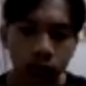

[[134  73  86  86]]


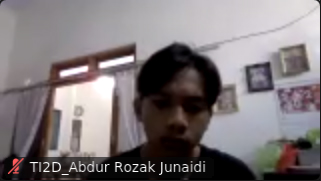

-1

In [ ]:
# Contoh implementasi dengan Sebuah Gambar

import numpy as np

# Read the input image
img = cv2.imread('/content/dataset_alpha/2D/Abdur Rozak Junaidi/foto_0003_1619959080621_Layer 4.jpg')

# Convert to gray
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
  
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

for (x, y, w, h) in faces:
    cropped_face = img[y:y+h, x:x+w]
    cv2_imshow(cropped_face)

print(faces)
  
cv2_imshow(img)
cv2.waitKey(0)